In [168]:
import pandas as pd
import numpy as np
import joblib

## ML libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from pygam import LogisticGAM, s

## visalization libraries
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:2f}'.format)

## Data Prep

In [169]:
master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')
master_trackman.head()

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/2981408051.py:1: DtypeWarning: Columns (91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-04-08,19:04:21.64,1,1,"Gilbert, Bradley",831228.000000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000000,Left,SEA_RED,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,-3.296976,-1.238717,2497.731876,193.680625,12:30,5.621390,0.510940,5.836200,-16.090760,18.231070,4.190400,1.212030,-0.291350,83.110150,-6.326811,-0.487350,0.421654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.463980,10.486150,-0.412500,50.000000,5.342850,2.649920,-130.679410,-8.015750,-4.299720,25.181650,-13.875380,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,18b54860-14e7-11f0-938f-b5417cf72451,89.391770,NaN,NaN,6.917910,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:04:21.64,2025-04-08T19:04:21.6401920-07:00,2025-04-09T02:04:21.6401920Z,NaN,v3,471486.000000,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1000114026.000000,Right,WAS_HUS,69bcc3f1-572b-4f97-8e16-e8d65a83174d,54.662890,-131.574870,12.590830,5.619120,-7.522340,-6.937690,-0.509450,2.802820,-2.149860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2025-04-08,19:04:34.59,1,2,"Gilbert, Bradley",831228.000000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000000,Left,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,1.675543,-0.415000,2782.722426,155.127014,11:15,5.533740,0.741550,4.993150,-35.983520,6.645160,-2.487760,4.117590,0.142400,75.363000,-4.887176,-0.853995,0.469918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118030,3.249250,-0.699510,50.000000,5.665960,0.971940,-119.219350,2.168950

In [170]:
## checking for duplicates in merged files
master_trackman = master_trackman.drop_duplicates(subset = ['PitchUID'])
master_trackman.shape[0]

1341142

In [171]:
master_trackman[master_trackman['KorBB'] == 'Strikeout']

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
43,44,2025-04-08,19:27:40.39,5,4,"Liddle, Brady",1000098674.000000,Right,SEA_RED,"Terry, Braedon",1000272652.000000,Left,WAS_HUS,Undefined,1,Bottom,2,1,2,ChangeUp,Changeup,StrikeCalled,Strikeout,Undefined,Undefined,1,0,78.589400,-0.490468,-4.020307,1424.149040,255.085961,2:30,5.537070,1.641810,5.920440,-38.580020,6.960000,20.385680,1.865790,-0.396250,71.726830,-7.637926,-0.365341,0.485700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.583080,4.182680,-1.330920,50.000000,5.475980,7.238470,-113.896610,-2.153380,-15.135370,21.947680,-26.708620,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,5a756070-14ea-11f0-938f-b5417cf72451,77.604410,NaN,NaN,6.862580,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:27:40.39,2025-04-08T19:27:40.3973120-07:00,2025-04-09T02:27:40.3973120Z,NaN,v3,471486.000000,4504,08 April 2025 21:05-seattleu@washington,"Cunnigan, Josh",1000239363.000000,Right,SEA_RED,652ccf8b-ed51-4692-8c31-99c1283c6b70,54.577970,-114.775380,10.973840,5.540790,-1.083980,-13.354310,-1.632880,7.844490,-7.567690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
79,80,2025-04-08,19:51:04.75,6,5,"Espinoza, Rafael",1000363484.000000,Right,SEA_RED,"Taggart, Casen",814470.000000,Left,WAS_HUS,Undefined,2,Bottom,2,2,2,Fastball,Four-Seam,StrikeCalled,Strikeout,Undefined,Undefined,1,0,93.375300,-2.568663,-5.273796,2408.259825,223.632239,1:30,5.919380,2.422970,5.614140,-12.274930,21.043670,18.807210,2.487280,-0.945840,83.360120,-4.980742,-1.935937,0.415446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.221700,11.843670,-1.983620,50.000000,5.691480,11.535

In [172]:
necessary_data = master_trackman[['Pitcher', 'PitcherTeam','PitcherThrows', 'BatterSide', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'RelSpeed', 'SpinRate', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ExitSpeed', 'Angle', 'Direction', 'Distance', 'Bearing', 'HangTime', 'PitchUID']]
necessary_data = necessary_data.dropna(subset = ['PitchCall', 'PlayResult'])
necessary_data

,Pitcher,PitcherTeam,PitcherThrows,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID
0,"Gilbert, Bradley",WAS_HUS,Right,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,2497.731876,12:30,5.621390,0.510940,5.836200,18.231070,4.190400,1.212030,-0.291350,NaN,NaN,NaN,NaN,NaN,NaN,18b54860-14e7-11f0-938f-b5417cf72451
1,"Gilbert, Bradley",WAS_HUS,Right,Left,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,2782.722426,11:15,5.533740,0.741550,4.993150,6.645160,-2.487760,4.117590,0.142400,NaN,NaN,NaN,NaN,NaN,NaN,205779d0-14e7-11f0-938f-b5417cf72451
2,"Gilbert, Bradley",WAS_HUS,Right,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,89.170310,2457.952019,12:30,5.673900,0.637670,6.021180,20.687960,4.343740,2.428360,-1.368630,NaN,NaN,NaN,NaN,NaN,NaN,298b6ed0-14e7-11f0-938f-b5417cf72451
3,"Gilbert, Bradley",WAS_HUS,Right,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,NaN,NaN,NaN,NaN,NaN,NaN,3189ca00-14e7-11f0-938f-b5417cf72451
4,"Gilbert, Bradley",WAS_HUS,Right,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,88.799670,2487.422652,12:45,5.699690,0.707000,5.903890,15.885320,5.797090,3.729990,-1.122990,NaN,NaN,NaN,NaN,NaN,NaN,445b4b40-14e7-11f0-938f-b5417cf72451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354508,"Hicks, Garrett",ARI_WIL,Right,Right,Cutter,Slider,StrikeCalled,Undefined,Undefined,Undefined,0,0,85.578950,2309.550718,11:00,5.343220,2.092230,6.157400,4.977010,-1.972250,2.480910,-0.516160,NaN,NaN,NaN,NaN,NaN,NaN,5bdd03d0-11d6-11f0-b75a-15defc8841bc
1354509,"Hicks, Garrett",ARI_WIL,Right,Right,Cutter,Slider,FoulBallNotFieldable,Undefined,Undefined,Undefined,0,0,87.422390,2299.056403,10:45,5.260250,2.269660,6.038550,6.124730,-3.600440,1.818140,0.106260,46.703320,50.600354,120.524254,116.274000,126.704006,3.081668,6451ee90-11d6-11f0-b75a-15defc8841bc
1354510,"Hicks, Garrett",ARI_WIL,Right,Right,Cutter,Slider,InPlay,Undefined,Popup,Out,1,0,87.589110,2338.856413,10:30,5.275490,2.220830,6.206060,4.687760,-3.380080,2.490030,-0.199540,68.609820,40.223331,-3.564189,197.333360,8.108297,4.536495,6f267430-11d6-11f0-b75a-15defc8841bc
1354511,"Hicks, Garrett",ARI_WIL,Right,Left,Cutter,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,85.486640,2312.444806,10:45,5.265290,2.252450,6.183890,7.524530,-4.503700,1.809560,-1.219740,NaN,NaN,NaN,NaN,NaN,NaN,82a5c1a0-11d6-11f0-b75a-15defc8841bc


In [173]:
necessary_data[necessary_data['KorBB'] != 'Undefined'].shape[0]

108111

In [174]:
necessary_data = necessary_data[
    (necessary_data['PitchCall'] == 'InPlay') | 
    (necessary_data['KorBB'].isin(['Strikeout']))
]

In [175]:
necessary_data['Hit'] = ((necessary_data['PlayResult'].isin(['Single', 'Double', 'Triple', 'Home Run', 'SIngle', 'Homerun', 'triple']))).astype(int)
necessary_data.head()

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/3968044900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['Hit'] = ((necessary_data['PlayResult'].isin(['Single', 'Double', 'Triple', 'Home Run', 'SIngle', 'Homerun', 'triple']))).astype(int)


,Pitcher,PitcherTeam,PitcherThrows,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit
10,"Gilbert, Bradley",WAS_HUS,Right,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0
17,"Gilbert, Bradley",WAS_HUS,Right,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1
23,"Gilbert, Bradley",WAS_HUS,Right,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0
28,"Liddle, Brady",SEA_RED,Right,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0
31,"Liddle, Brady",SEA_RED,Right,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0


In [176]:
feature_cols = ['ExitSpeed', 'Angle', 'Direction']
target_col = ['Hit']

In [177]:
necessary_data[feature_cols] = necessary_data[feature_cols].fillna(0)

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/1382998981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data[feature_cols] = necessary_data[feature_cols].fillna(0)


In [178]:
X = necessary_data[feature_cols].values
y = necessary_data[target_col].values

## Logistic GAM (xBA)

In [179]:
from pygam import LogisticGAM, s
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
import numpy as np

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# define GAM
gam = LogisticGAM(s(0) + s(1) + s(2), fit_intercept=True, max_iter=100)

# use pygam’s internal k-fold CV to select smoothing
gam.gridsearch(X_train, y_train, progress=False)

# evaluate on test set
y_pred_proba = gam.predict_mu(X_test)  

test_logloss = log_loss(y_test, y_pred_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_brier = brier_score_loss(y_test, y_pred_proba)

print("Test log-loss:", test_logloss)
print("Test AUC:", test_auc)
print("Test Brier score:", test_brier)


Test log-loss: 0.3930167414617088
Test AUC: 0.8498097190152809
Test Brier score: 0.12528665041924647


In [180]:
necessary_data['xBA'] = gam.predict_mu(X).round(3)

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_19804/2617999836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['xBA'] = gam.predict_mu(X).round(3)


In [181]:
necessary_data

,Pitcher,PitcherTeam,PitcherThrows,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,xBA
10,"Gilbert, Bradley",WAS_HUS,Right,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0.061000
17,"Gilbert, Bradley",WAS_HUS,Right,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,0.324000
23,"Gilbert, Bradley",WAS_HUS,Right,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0.115000
28,"Liddle, Brady",SEA_RED,Right,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0.067000
31,"Liddle, Brady",SEA_RED,Right,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0.097000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354497,"Butler, Joshua",ARI_SUN,Right,Right,Sinker,Sinker,StrikeSwinging,Strikeout,Undefined,StolenBase,1,0,91.655590,2068.840931,2:30,6.196620,1.725330,5.944610,4.510440,14.108350,2.357360,-0.755560,0.000000,0.000000,0.000000,NaN,NaN,NaN,85521260-11d5-11f0-b75a-15defc8841bc,0,0.025000
1354499,"Butler, Joshua",ARI_SUN,Right,Right,Sinker,Sinker,InPlay,Undefined,LineDrive,Out,1,0,91.193830,2042.285066,1:45,6.246710,1.790860,5.819640,11.101780,14.284570,2.141930,0.133940,104.723420,20.422854,2.016651,363.519210,1.596601,4.250750,a83f1ca0-11d5-11f0-b75a-15defc8841bc,0,0.490000
1354507,"Hicks, Garrett",ARI_WIL,Right,Left,Cutter,Slider,StrikeCalled,Strikeout,Undefined,Undefined,1,0,85.907920,2260.969161,11:30,5.317150,2.320680,5.912120,6.148780,-1.020280,2.311980,0.986710,0.000000,0.000000,0.000000,NaN,NaN,NaN,485f15f0-11d6-11f0-b75a-15defc8841bc,0,0.025000
1354510,"Hicks, Garrett",ARI_WIL,Right,Right,Cutter,Slider,InPlay,Undefined,Popup,Out,1,0,87.589110,2338.856413,10:30,5.275490,2.220830,6.206060,4.687760,-3.380080,2.490030,-0.199540,68.609820,40.223331,-3.564189,197.333360,8.108297,4.536495,6f267430-11d6-11f0-b75a-15defc8841bc,0,0.069000


In [184]:
xBA_ucsd = necessary_data[necessary_data['PitcherTeam'] == 'CSD_TRI'].groupby(['Pitcher', 'AutoPitchType']).agg({'Hit': 'sum', 'xBA': 'mean', 'PitchUID': 'count'}).reset_index()
xBA_ucsd['BA'] = round(xBA_ucsd['Hit'] / xBA_ucsd['PitchUID'], 3)
xBA_ucsd[xBA_ucsd['PitchUID'] >= 8].sort_values('xBA', ascending = True)

,Pitcher,AutoPitchType,Hit,xBA,PitchUID,BA
63,"Ries, Nathan",Slider,0,0.064600,10,0.000000
78,"Weber, Chapman",Slider,0,0.128875,8,0.000000
35,"King, Devon",Slider,2,0.131719,32,0.062000
60,"Ries, Nathan",Changeup,1,0.145667,9,0.111000
65,"Seid, Spencer",Curveball,1,0.152364,11,0.091000
75,"Villar, Jake",Slider,5,0.156433,30,0.167000
68,"Seid, Spencer",Sinker,7,0.172983,59,0.119000
37,"Marchetti, Landon",Curveball,1,0.187875,8,0.125000
17,"Ernisse, Zach",Four-Seam,3,0.194846,13,0.231000
67,"Seid, Spencer",Four-Seam,5,0.213576,33,0.152000


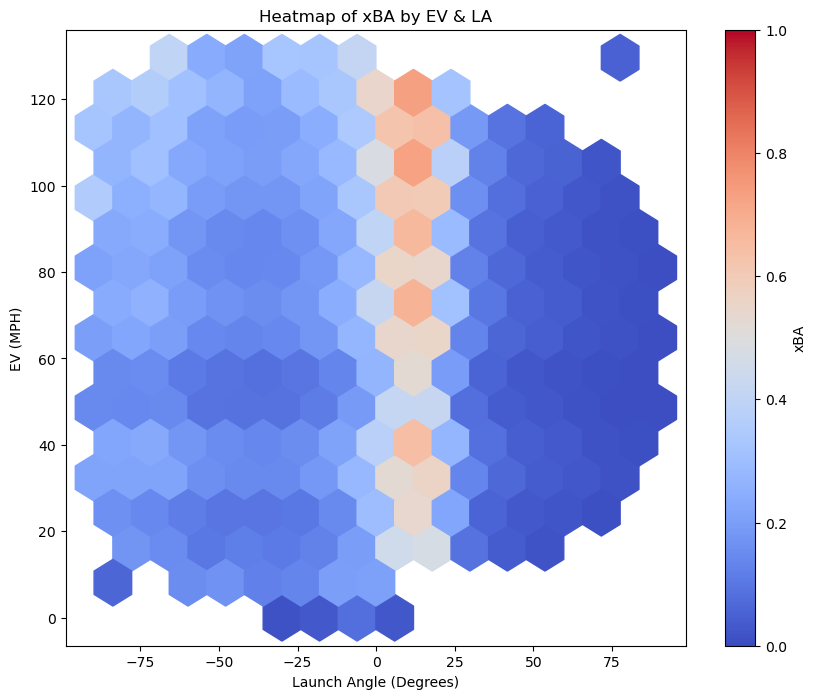

In [183]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

hb = plt.hexbin(
    necessary_data['Angle'],
    necessary_data['ExitSpeed'],
    C=necessary_data['xBA'],
    gridsize=15,        # controls resolution
    cmap='coolwarm',
    vmin=0.00,
    vmax=1.00
)

plt.colorbar(hb, label='xBA')
plt.xlabel("Launch Angle (Degrees)")
plt.ylabel("EV (MPH)")
plt.title("Heatmap of xBA by EV & LA")

plt.show()